## Salary Analysis

### Using the data at hand I will attempt to answer the following questions.
##### How much does a degree matter in trying to attain a high paying job.? How much will taking out the degree factor help people now in attaining higher paying jobs?
##### How well can we predict an individual's salary? What aspects correlate well to salary?
##### How well can we predict previous prerequisites for scoring a high paying job?

In [1]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

In [2]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

In [3]:
#clean the data - remove duplicates and salaries that are $0
def clean_d(original_df):
    clean_d = original_df.drop_duplicates(subset='jobId')
    clean_d = original_df[original_df.salary>0]
    return clean_d

In [4]:
#scatter plots 
def scatter_data(df, col):
    plt.figure(figsize = (12,8))
    plt.scatter(df[col], df['salary'] )
    plt.ylabel('salary')
    plt.xlabel(col)

In [5]:
#regression plots
def reg_data(df, col):
    plt.figure(figsize=(12,8))
    sns.regplot(x=df[col], y = df['salary'], data = df, line_kws = {'color' : 'red'})    
    plt.ylim(0,)

In [6]:
#residual plots 
def res_data(df,col):
    plt.figure(figsize=(12,8))
    sns.residplot(x=df[col], y = df['salary'], data = df)
    plt.show()

In [7]:
#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.title(title)
    plt.show()
    plt.close()

In [8]:
#load data
print("Loading data..")
train_feat_df = load_f('train_features.csv')
train_target_df = load_f('train_salaries.csv')

#define the variables
cat_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_vars = ['yearsExperience', 'milesFromMetropolis']
tar = 'salary'

#verify data is laoded 
train_feat_df.head()

Loading data..


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10.0,83.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3.0,73.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10.0,38.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8.0,17.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8.0,16.0


In [9]:
#verify data is loaded - 
train_target_df.head()

,jobId,salary
0,JOB1362684407687,130.0
1,JOB1362684407688,101.0
2,JOB1362684407689,137.0
3,JOB1362684407690,142.0
4,JOB1362684407691,163.0


##### Check length and datatypes

In [10]:
train_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199034 entries, 0 to 199033
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   jobId                199034 non-null  object 
 1   companyId            199034 non-null  object 
 2   jobType              199034 non-null  object 
 3   degree               199034 non-null  object 
 4   major                199033 non-null  object 
 5   industry             199033 non-null  object 
 6   yearsExperience      199033 non-null  float64
 7   milesFromMetropolis  199033 non-null  float64
dtypes: float64(2), object(6)
memory usage: 12.1+ MB


In [11]:
train_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136113 entries, 0 to 136112
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   jobId   136113 non-null  object 
 1   salary  136112 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.1+ MB


In [12]:
#shape of the data
print(train_feat_df.shape)
print(train_target_df.shape)

(199034, 8)
(136113, 2)


##### Merge both dataFrames

In [13]:
#merge training data with features and training data with salary - store in train_df
train_df = pd.merge(train_feat_df,train_target_df, on = 'jobId')

In [14]:
#verify features on merged data
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10.0,83.0,130.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3.0,73.0,101.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10.0,38.0,137.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8.0,17.0,142.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8.0,16.0,163.0


In [15]:
#verify shape of the merged data-
print(train_df.shape)

(136112, 9)


##### Check for missing values.

In [16]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

##### No missing values. Let's clean the data.

In [17]:
#store the the salaries in the training data which are less than or equal to 0
zero_sal = train_df['salary']<=0
inval = train_df[zero_sal]
inval

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11.0,7.0,0.0


##### We have found some corrupt data, a job type with salary as 0 however jobType, degree, major, etc do not justify that these positions are of volunteer level. It's better for us to remove this piece of data.

In [18]:
#clean the data i.e, remove duplicates and remove the salaries that are invalid or not useful for predictions like salary<=0
#calling the function
clean_train_df = clean_d(train_df)

In [19]:
print(clean_train_df.shape)

(136111, 9)


In [20]:
#Reset the index values after dropping the invalid values 
clean_train_df.reset_index(drop = True)
clean_train_df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
136107,JOB1362684543794,COMP14,CTO,HIGH_SCHOOL,NONE,EDUCATION,20.0,86.0,109.0
136108,JOB1362684543795,COMP28,SENIOR,BACHELORS,NONE,OIL,15.0,98.0,119.0
136109,JOB1362684543796,COMP57,CTO,NONE,NONE,HEALTH,12.0,43.0,121.0
136110,JOB1362684543797,COMP55,CTO,DOCTORAL,BIOLOGY,WEB,17.0,22.0,139.0
136111,JOB1362684543798,COMP28,SENIOR,DOCTORAL,BIOLOGY,WEB,21.0,26.0,154.0


##### Check dataTypes

In [21]:
print(clean_train_df.dtypes)

jobId                   object
companyId               object
jobType                 object
degree                  object
major                   object
industry                object
yearsExperience        float64
milesFromMetropolis    float64
salary                 float64
dtype: object


## Data Analysis

In [22]:
clean_train_df.describe()

,yearsExperience,milesFromMetropolis,salary
count,136111.000000,136111.000000,136111.000000
mean,11.965286,49.441919,115.911778
std,7.213364,28.893065,38.741714
min,0.000000,0.000000,19.000000
25%,6.000000,24.000000,88.000000
50%,12.000000,49.000000,114.000000
75%,18.000000,74.000000,141.000000
max,24.000000,99.000000,292.000000


##### Looks good!

In [23]:
#count of unique values in categorical data
for cat in cat_vars:
    if cat != 'jobId' and cat != 'companyId':
       print(clean_train_df[cat].value_counts())

JANITOR           17163
CEO               17105
SENIOR            17099
VICE_PRESIDENT    17094
CTO               17018
JUNIOR            16908
MANAGER           16893
CFO               16831
Name: jobType, dtype: int64
NONE           32543
HIGH_SCHOOL    32386
DOCTORAL       23808
MASTERS        23739
BACHELORS      23635
Name: degree, dtype: int64
NONE           72865
LITERATURE      7983
BUSINESS        7977
ENGINEERING     7963
CHEMISTRY       7947
COMPSCI         7889
PHYSICS         7864
BIOLOGY         7862
MATH            7761
Name: major, dtype: int64
AUTO         19585
HEALTH       19519
FINANCE      19516
SERVICE      19512
EDUCATION    19388
WEB          19349
OIL          19242
Name: industry, dtype: int64


In [24]:
# unique values in clean_train_df data -
clean_train_df.nunique()

jobId                  136111
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    265
dtype: int64

##### Let's drop jobId since its is unique to reduce noise in prediction.
##### Are salaries distributed normally?

In [25]:
#compute the kurtosis and skewness of salary
print('Salary Skewness:', clean_train_df['salary'].skew())
print('Salary Kurtosis:', clean_train_df['salary'].kurt())
print('\n')
if -0.5 <= clean_train_df['salary'].skew() <= 0.5:
    print('Salary distribution is approximately symmetric')
elif -0.5 >  clean_train_df['salary'] > 0.5:
    print('Salary distribution is skewed')

Salary Skewness: 0.3451829927916626
Salary Kurtosis: -0.016673478929278396


Salary distribution is approximately symmetric


### Visualizing Salary

In [26]:
#We use IQR to identify potential outliers 

stats = clean_train_df['salary'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper_bound, lower_bound))

The upper and lower bounds for suspected outliers are 220.5 and 8.5.


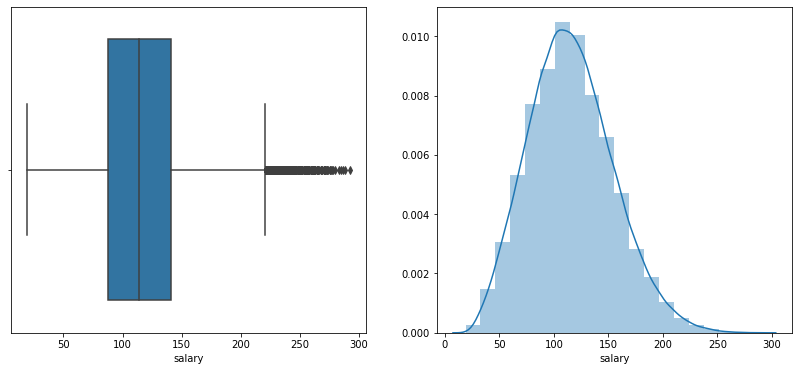

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(clean_train_df['salary'])
plt.subplot(1,2,2)
sns.distplot(clean_train_df['salary'], bins = 20)
plt.show()

##### Since the lower outliers were already sorted earlier by dropping 0 salary data. Let's focus on the above outliers.

In [29]:
#Examine potential outliers above the upper bound - 
clean_train_df.loc[clean_train_df['salary'] > 220.5, 'jobType'].value_counts()

CEO               443
CTO               218
CFO               198
VICE_PRESIDENT     78
MANAGER            20
SENIOR              8
JUNIOR              4
Name: jobType, dtype: int64

In [30]:
#Examine the outliers for a particular type(JUNIOR) of column, jobType - 
clean_train_df[(clean_train_df['salary'] > 220.5) & (clean_train_df['jobType'] == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24.0,5.0,225.0
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24.0,3.0,246.0
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24.0,0.0,225.0
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23.0,8.0,248.0


#### Visualize numerical salary data.

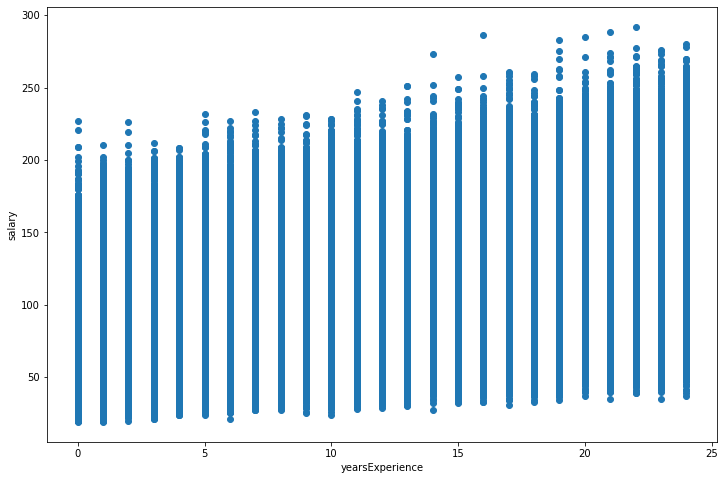

In [31]:
##Calling the function
scatter_data(clean_train_df, 'yearsExperience')

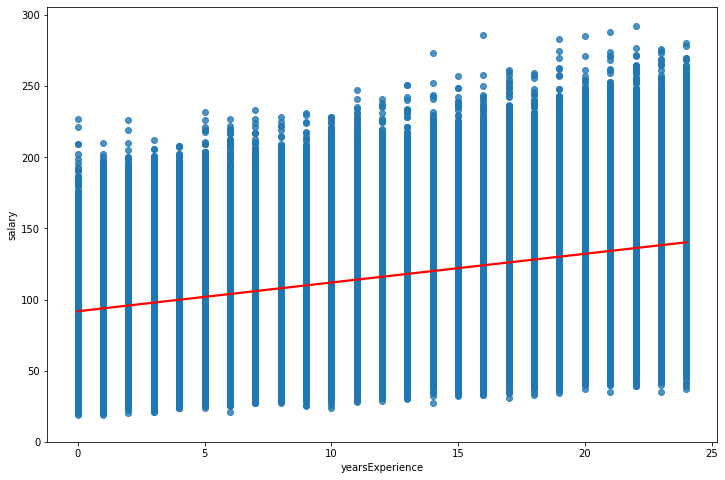

In [32]:
#Fit a regression line to years experience to visualize it as a predictor of salary - 
#Calling the function
reg_data(clean_train_df, 'yearsExperience')

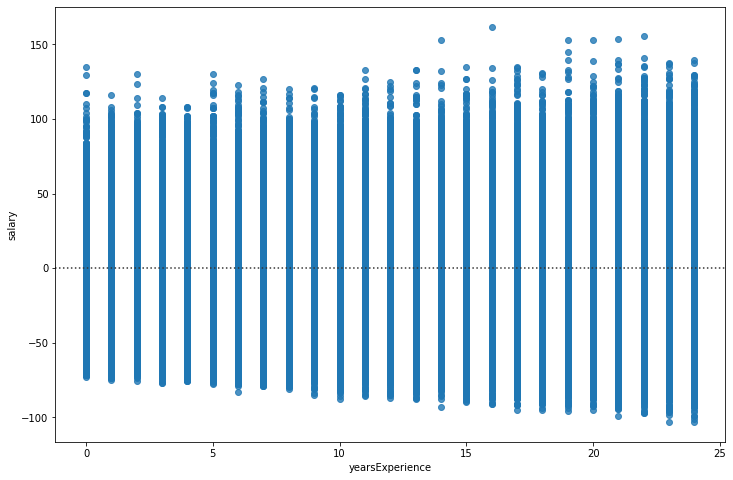

In [33]:
#Variance of yearsExperience-
#Calling the function
res_data(clean_train_df, 'yearsExperience')

#### There seems to be a weak positive relationship in salary due to yearsExperience

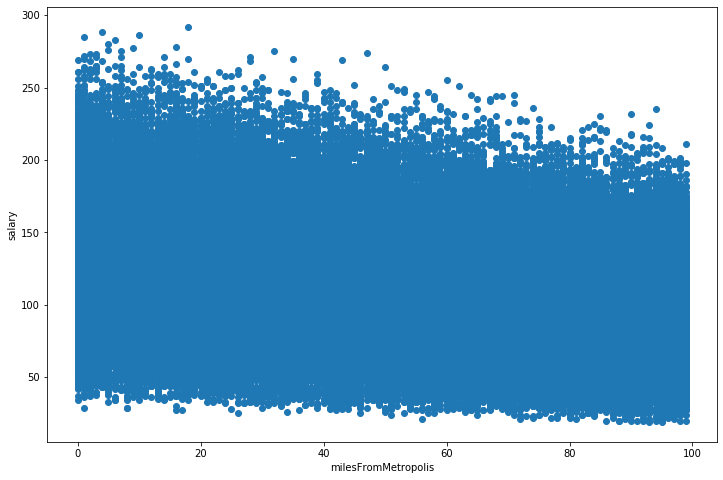

In [34]:
scatter_data(clean_train_df, 'milesFromMetropolis')

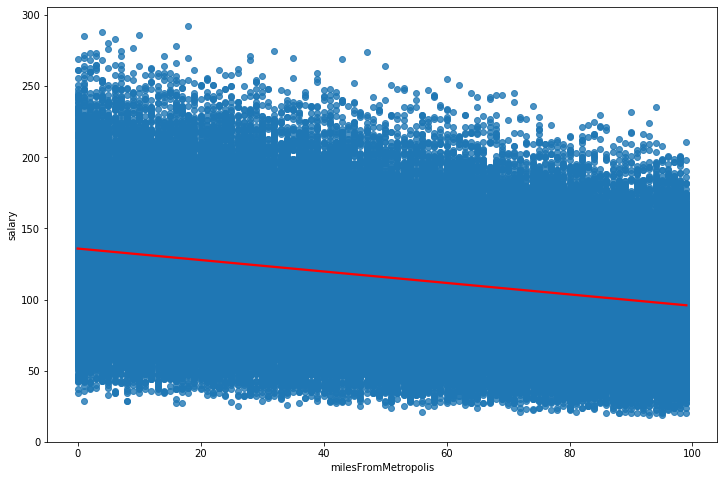

In [35]:
#Fit a regression line to miles from metropolis to visualize it as a predictor of salary -
reg_data(clean_train_df, 'milesFromMetropolis')

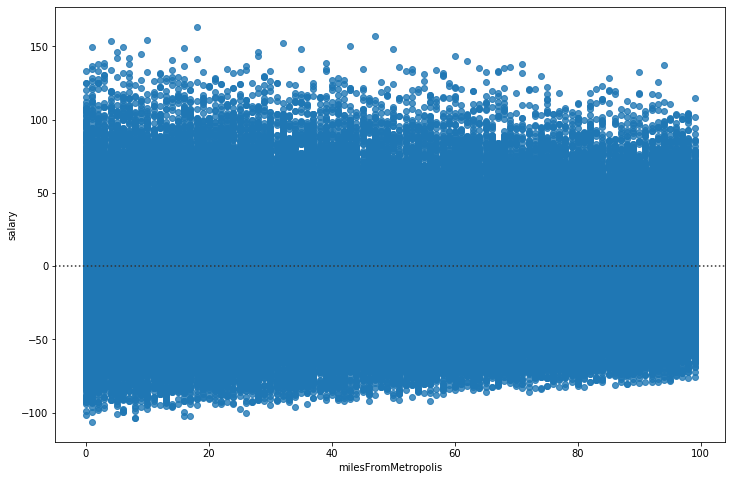

In [36]:
#Variance of milesfrom Metropolis
res_data(clean_train_df, 'milesFromMetropolis')

#### We can see a weak negative relationship between miles from metropolis and salary.
### Relationships with categorical features-

In [37]:
# drop jobId and companyId 
clean_train_df.drop(['jobId'], axis = 1, inplace = True)
clean_train_df.drop(['companyId'], axis = 1, inplace = True)

In [38]:
clean_train_df.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10.0,83.0,130.0
1,CEO,HIGH_SCHOOL,NONE,WEB,3.0,73.0,101.0
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10.0,38.0,137.0
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8.0,17.0,142.0
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8.0,16.0,163.0


#### Next will use the violin plot to see the shape of the distribution curve along with mean and interquartile ranges to see categorical predictors of salary.

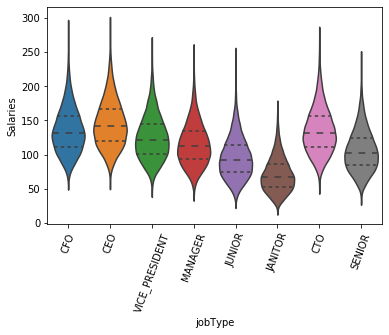

In [39]:
sns.violinplot(x = clean_train_df.jobType, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

#### We can see positive correlation between jobType and salary.

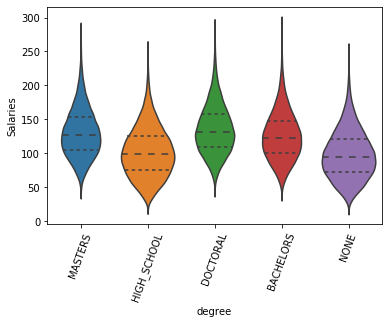

In [40]:
sns.violinplot(x = clean_train_df.degree, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

#### We can see salary increase with degree.

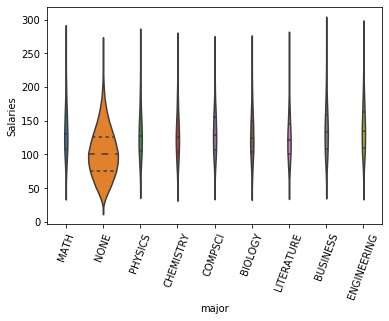

In [41]:
sns.violinplot(x = clean_train_df.major, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

#### It is clear here that having no major corresponds with those who do not posses a degree or only posses HighSchool diploma.

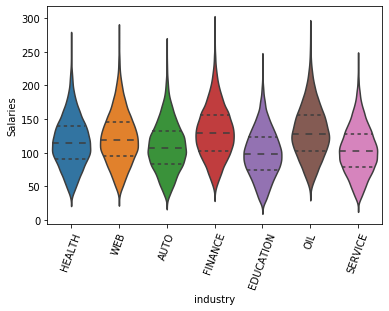

In [42]:
sns.violinplot(x = clean_train_df.industry, y = clean_train_df['salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries')
plt.show()

In [43]:
## One-hot encode categorical data in clean_train_df dataset
clean_train_df = pd.get_dummies(clean_train_df)

In [44]:
clean_train_df.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10.0,83.0,130.0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3.0,73.0,101.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10.0,38.0,137.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8.0,17.0,142.0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8.0,16.0,163.0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


#### Now let's see correlation between all features.

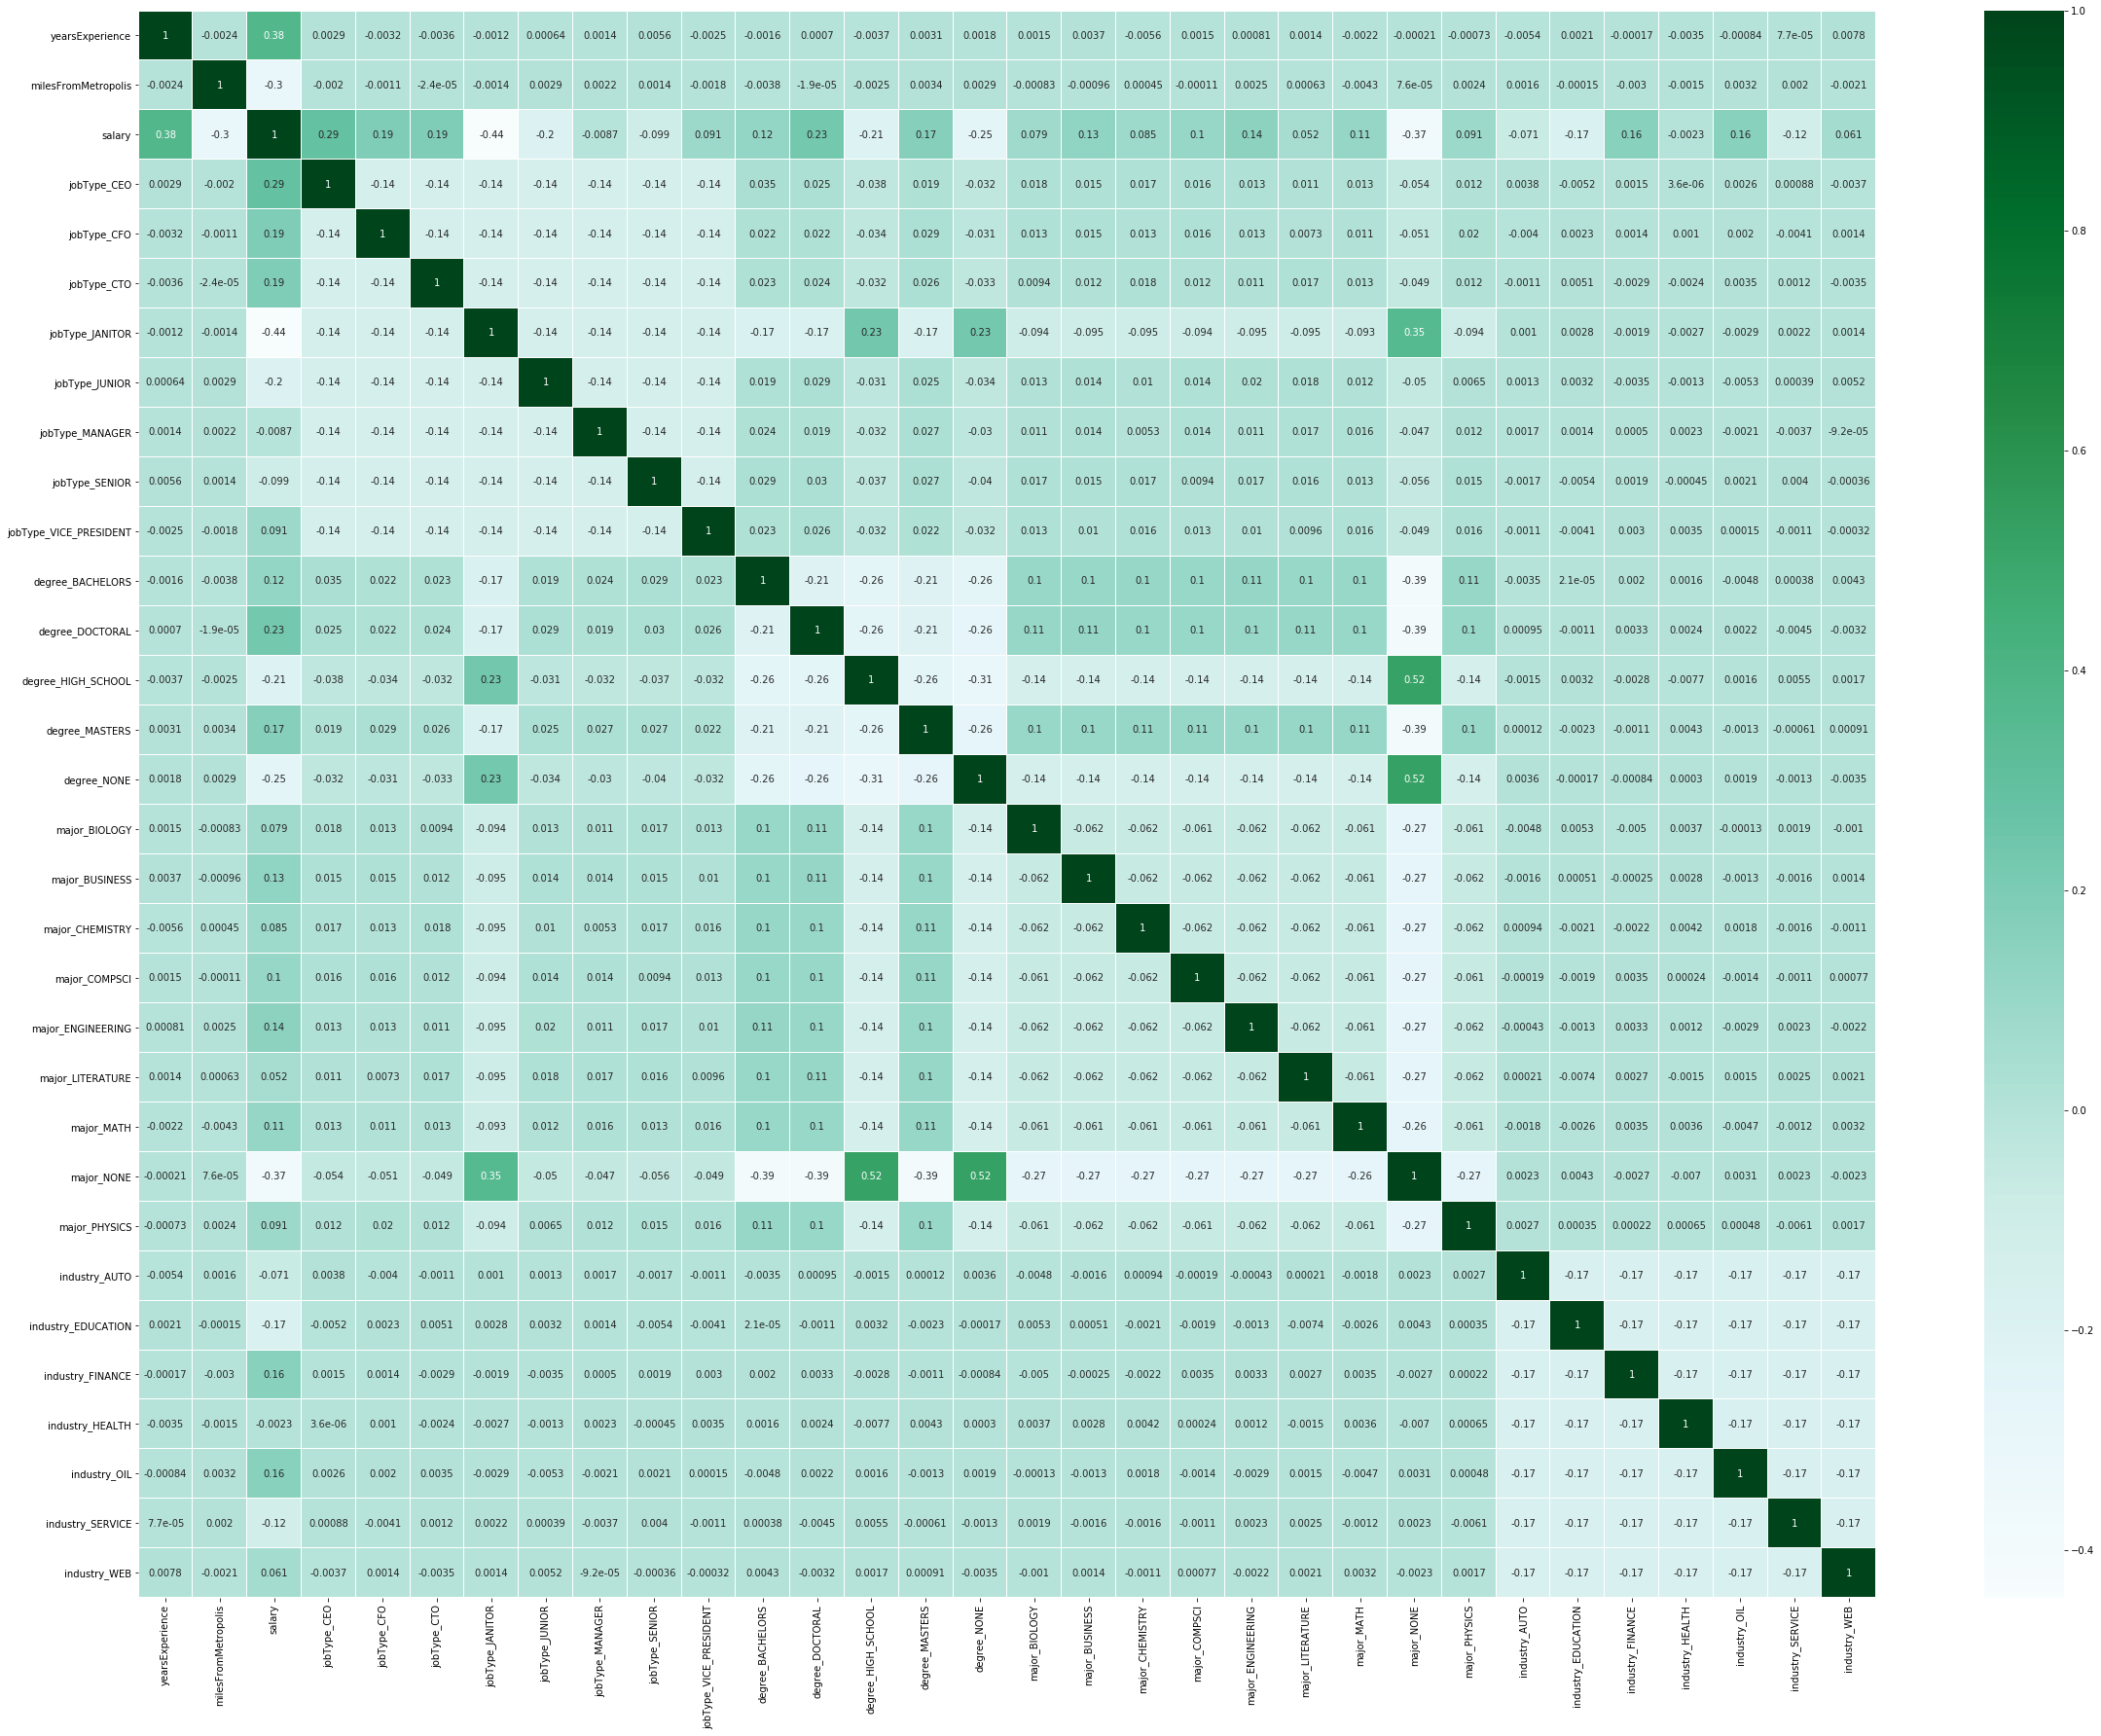

In [45]:
# Plot heatmap of all data with correlation coefficients visible
clean_train_df_corr = clean_train_df.corr()
plt.subplots(figsize=(40,30))
sns.heatmap(clean_train_df_corr, cmap = 'BuGn', linewidth =.005, annot = True)

#### To create a basic training model, two variables will be assigned for the model to use. Twenty percent of the training data will be split into testing data that we can use to test the model with data for which the salaries are already known.

In [46]:
#Split the data and assign 'salary' to 'sal_df' and the rest of the features to 'feat_df'. 
feat_df = clean_train_df[clean_train_df.loc[ :, clean_train_df.columns != 'salary'].columns]
sal_df = clean_train_df['salary']
feat_train, feat_test, sal_train, sal_test = train_test_split(feat_df, sal_df, test_size = 0.2, random_state = 1)

In [47]:
#View inputs and outputs of training model
feat_train.head()

,yearsExperience,milesFromMetropolis,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
41385,15.0,60.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
73048,5.0,1.0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
125043,23.0,98.0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
5330,9.0,19.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20853,5.0,5.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [48]:
sal_train.head()

41385     140.0
73048     127.0
125043     94.0
5330      183.0
20853      99.0
Name: salary, dtype: float64

#### We will use linear regression here as salary is a continious variable. We will establish the baseline model by appling Linear Regression to feat_train, sal_train.

In [49]:
#Create Linear Regression Object and fit the model
lm = LinearRegression()
lm.fit(feat_train,sal_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Examine coefficients model

In [50]:
#View coeff of Linear Regression object 
print(lm.intercept_)
print(lm.coef_)

148930538937.59622
[ 2.01891819e+00 -4.01452408e-01 -8.04603118e+10 -8.04603118e+10
 -8.04603118e+10 -8.04603119e+10 -8.04603119e+10 -8.04603118e+10
 -8.04603118e+10 -8.04603118e+10 -1.36913812e+10 -1.36913811e+10
 -1.36913812e+10 -1.36913812e+10 -1.36913812e+10 -4.57636191e+09
 -4.57636190e+09 -4.57636191e+09 -4.57636190e+09 -4.57636190e+09
 -4.57636191e+09 -4.57636190e+09 -4.57636191e+09 -4.57636190e+09
 -5.02024839e+10 -5.02024839e+10 -5.02024839e+10 -5.02024839e+10
 -5.02024839e+10 -5.02024839e+10 -5.02024839e+10]


In [51]:
#predict salary using training data
yhat = lm.predict(feat_train)

#View first five predictions -
print ('First five predictions:' , yhat[0:5])

First five predictions: [132.21765137 104.14154053 103.99404907 153.15472412 104.88272095]


#### Let's calculate MSE along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model.

In [52]:
#print MSE - 
print ('Mean Squared Error of our prediction model', mean_squared_error(sal_train, yhat))

Mean Squared Error of our prediction model 386.15121925107945


#### Cross Validation

In [53]:
# accuracy of the baseline model using 5-cross validation method -
score = cross_val_score(lm, feat_train, sal_train, cv = 5)
print ('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.742833633864189 0.0013333219410143727


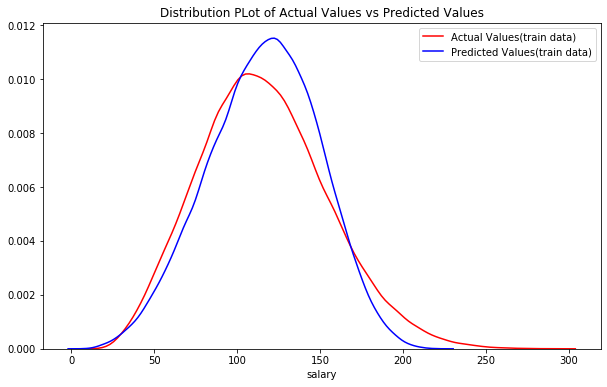

In [54]:
#distribution plot 
#Calling the function
Title = 'Distribution PLot of Actual Values vs Predicted Values'
dis_data(sal_train, yhat, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

#### Mean of the predicted values seems higher and the range seems lower.
#### Let's see if 20% test data has similar outcome.

In [55]:
#store test set predictions in yhat_test 
yhat_test = lm.predict(feat_test)

#view first five predictions - 
print ('First five predictions(test data)', yhat_test[0:5])

First five predictions(test data) [170.09329224 126.16101074 107.23275757  95.39996338 145.76373291]


In [56]:
#MSE of test data - 
print ('Mean Squared Error of test data ', mean_squared_error(sal_test, yhat_test))

Mean Squared Error of test data  384.43877887884304


#### MSE is very similar for both training and test data.

In [57]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(lm, feat_test, sal_test, cv = 5)
print ('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.7422277148088259 0.007379499671059188


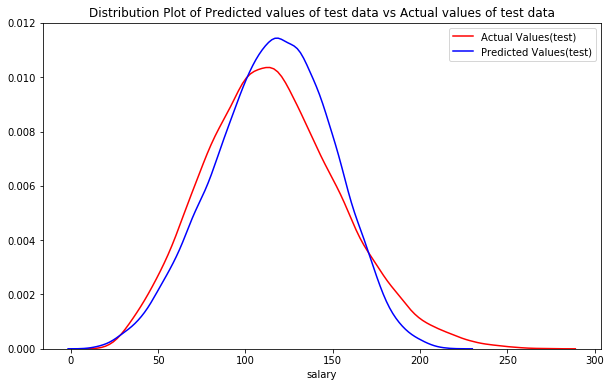

In [58]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data'
dis_data(sal_test, yhat_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

#### Let's apply models on data to try reducing the MSE to less than 360.
#### Let's check the shape and features of our datasets.

In [59]:
#shape and features -

print ('Number of training samples-', feat_train.shape, '\n with the features-', feat_train.columns)
print ('Number of testing samples-', feat_test.shape, '\n with the features-', feat_test.columns)
print ('Number of training salaries-', sal_train.shape)
print ('Number of testing salaries-', sal_test.shape)

Number of training samples- (108888, 31) 
 with the features- Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELORS',
       'degree_DOCTORAL', 'degree_HIGH_SCHOOL', 'degree_MASTERS',
       'degree_NONE', 'major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY',
       'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH',
       'major_NONE', 'major_PHYSICS', 'industry_AUTO', 'industry_EDUCATION',
       'industry_FINANCE', 'industry_HEALTH', 'industry_OIL',
       'industry_SERVICE', 'industry_WEB'],
      dtype='object')
Number of testing samples- (27223, 31) 
 with the features- Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CEO', 'jobType_CFO',
       'jobType_CTO', 'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_BACHELOR

#### Let's try applying Polynomial Features to already built Linear regression model inorder to reduce the MSE to lower than 360.

In [60]:
#Fit and transform the variables with 2nd order polynomial
pr = PolynomialFeatures(2)
feat_train_pr = pr.fit_transform(feat_train)
feat_test_pr = pr.fit_transform(feat_test)
pr

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [61]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(feat_train_pr, sal_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
#make predictions and view first five predictions on train data - 
yhat_pr = poly.predict(feat_train_pr)
print ('First five predictions(train data)-', yhat_pr[0:5])

First five predictions(train data)- [122.97188975  98.29446675  92.68541361 149.2083409  112.25149705]


In [63]:
#Compare first five predicted values vs actual values - 
print ('Predicted Values(train)-', yhat_pr[0:5])
print ('Actual Values(train)-', sal_train[0:5].values)

Predicted Values(train)- [122.97188975  98.29446675  92.68541361 149.2083409  112.25149705]
Actual Values(train)- [140. 127.  94. 183.  99.]


In [64]:
#make predictions and view first five predictions on test data - 
yhat_prtest = poly.predict(feat_test_pr)
print ('First five predictions(test data)-', yhat_prtest[0:5])


First five predictions(test data)- [188.08379008 125.54640032 107.48739173  92.45599915 134.94720377]


In [65]:
#Compare predicted values of test data and actual values of test data - 
print ('Predicted values(test)-', yhat_prtest[0:5])
print ('Actual values(test)-', sal_test[0:5].values)

Predicted values(test)- [188.08379008 125.54640032 107.48739173  92.45599915 134.94720377]
Actual values(test)- [238. 102.  87. 115. 112.]


In [66]:
#print R-squared values of training and testing data - 
print ('R-squared of training data-', poly.score(feat_train_pr, sal_train))
print ('R-squared of testing data-', poly.score(feat_test_pr, sal_test))

R-squared of training data- 0.7641905452693074
R-squared of testing data- 0.7628113350752511


In [67]:
#MSE of training and testing data - 
print ('MSE of training data-', mean_squared_error(sal_train, yhat_pr))
print ('MSE of testing data-', mean_squared_error(sal_test, yhat_prtest))

MSE of training data- 354.32236104053237
MSE of testing data- 354.40208958109025


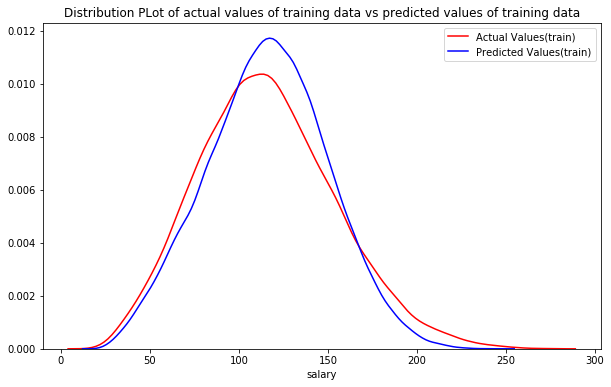

In [68]:
#View distribution plot of actual vs fitted of training data - 
dis_data(sal_test, yhat_pr, 'Actual Values(train)', 'Predicted Values(train)', title = 'Distribution PLot of actual values of training data vs predicted values of training data')

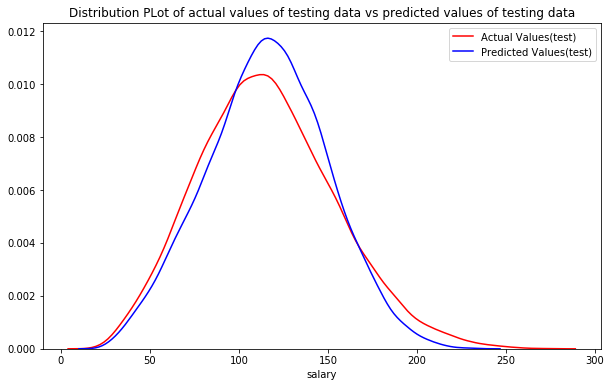

In [69]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sal_test, yhat_prtest, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution PLot of actual values of testing data vs predicted values of testing data')

#### Random Forest

In [70]:
#create a random forest object - 
RF = RandomForestRegressor(n_estimators = 150, n_jobs = 2, max_features = 30)
RF

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [71]:
#fit a Random Forest model on training data - 
RF.fit(feat_train, sal_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [75]:
#make predictions on testing data and print the first five - 
yhat_RF_test = RF.predict(feat_test)
print ('First five predictions-', yhat_RF_test[0:5])

First five predictions- [181.48       111.09866667 106.47333333  97.12566667 130.59333333]


In [77]:
#R-squared and MSE of test data - 
print ('R-squared of test data-', RF.score(feat_test, sal_test))
print ('MSE of test data-', mean_squared_error(sal_test, yhat_RF_test))

R-squared of test data- 0.716148077960252
MSE of test data- 424.1253026758733
